In [1]:
from ultralytics import YOLO
import cv2
import math
import torch
import numpy as np

c:\Users\ditec\anaconda3\envs\recursion5\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GENERIC_WEIGHTS = "D:/RajHack/Rakshak/video-server/models/weights/yolo_v8/yolov8n.pt"
FIRE_WEIGHTS = "firedetection.pt"
WEAPONS_WEIGHTS = "weapons detection/best.pt"

In [3]:
classes = {
    "generic": ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ],
    "fire" : ["fire","smoke"],
    "weapons" : ["Grenade","Handgun","Rifle","Steel arms"]
}

In [4]:
models = {}
models["generic"] = YOLO("yolov8n.pt")
models["fire"] = YOLO(FIRE_WEIGHTS)
models["weapons"] = YOLO(WEAPONS_WEIGHTS)

In [5]:
import time

In [25]:
import pandas as pd
import os

def create_csv():
  try:
    df = pd.read_csv('anomalies.csv')
  except FileNotFoundError:
    df = pd.DataFrame(columns=['Timestamp','Type of anomaly' ,'Number of People present', 'Path of image'])
    df.to_csv('anomalies.csv', index=False)
  return df


def append_to_csv(df, timestamp, num_inmates, image_path, typeofanomaly=""):
  new_data = {'Timestamp': timestamp, 'Type of anomaly':typeofanomaly, 'Number of People present': num_inmates, 'Path of image': image_path}
  new_data_df = pd.DataFrame.from_dict(new_data, orient='index').T
  df = pd.concat([df, new_data_df], ignore_index=True)
  df.to_csv('anomalies.csv', index=False)

inmatesthresholdtime = 15
anomaly_count = {} 
df = create_csv()

def process_model(model, img, classNames, model_name, numinmates , savetodir="frames"):
    global inmatesthresholdtime, anomaly_count, df
    
    results = model(img, stream=True)
    inmates = 0
    anomalies = []
    typeofanomaly = {
            "generic": "overcrowding",
            "fire": "Fire",
            "weapons": "Weapons"
        }
    for r in results:
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            confidence = math.ceil((box.conf[0]*100))/100
            if confidence < 0.5:
                continue
            if cls >= len(classNames):
                print("Error: Class index out of range")
                continue
            accepted_list = ["person", "fire", "Grenade", "Handgun", "Rifle", "Steel arms"]
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
            if model_name == "generic" and classNames[cls] == "person":
                inmates += 1
            if classNames[cls] in accepted_list:
                anomaly_key = (model_name, classNames[cls])
                anomaly_count[anomaly_key] = anomaly_count.get(anomaly_key, 0) + 1
                if anomaly_count[anomaly_key] >= 5:
                    timestamp = time.strftime('%Y-%m-%d %H:%M:%S') 
                    anomaly_text = f"{classNames[cls]} detected, storing the frame in the database as {savetodir}/{timestamp}.jpg at {timestamp}"
                    print(anomaly_text)
                    anomalies.append(anomaly_text)
                    anomaly_count[anomaly_key] = 0
                    df = create_csv()
                    append_to_csv(df, timestamp, inmates, f"{savetodir}/{timestamp}.jpg", typeofanomaly[model_name])
                    oath = f"{savetodir}/{timestamp}.jpg"
                    # create the directory if it does not exist
                    if not os.path.exists(savetodir):
                        os.makedirs(savetodir)
                    cv2.imwrite(filename=f"{savetodir}/{timestamp}.jpg", img=img)
                    
            print("Confidence --->", confidence)
            print("Class name -->", classNames[cls])
            org = [x1, y1]
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1
            color = (255, 0, 0)
            thickness = 2
            cv2.putText(img, classNames[cls], org, font, fontScale, color, thickness)

    if inmatesthresholdtime <= 0:
        inmatesthresholdtime = 15
    else:
        inmatesthresholdtime -= 1
    with open("anomalies.txt", "a") as f:
        f.write("\n".join(anomalies) + "\n")

     
def start_webcam(models, classes):
  cap = cv2.VideoCapture(0)
  while True:
    ret, frame = cap.read()
    if not ret:
      print("Error: Unable to capture frame")
      break
    for model_name, model in models.items():
      process_model(model, frame.copy(), classes[model_name], model_name, 10)  # Pass a copy of frame to avoid modification across models
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  cap.release()
  cv2.destroyAllWindows()

In [26]:
start_webcam(models=models, classes=classes)


0: 480x640 1 person, 117.1ms
Confidence ---> 0.84
Class name --> person
Speed: 0.0ms preprocess, 117.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x800 1 default, 348.7ms
Confidence ---> 0.79
Class name --> smoke
Speed: 3.3ms preprocess, 348.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 800)

0: 352x448 1 Steel arms, 306.2ms
Confidence ---> 0.5
Class name --> Steel arms
Speed: 0.0ms preprocess, 306.2ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 448)

0: 480x640 1 person, 137.4ms
Confidence ---> 0.87
Class name --> person
Speed: 7.0ms preprocess, 137.4ms inference, 12.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x800 1 default, 400.5ms
Confidence ---> 0.75
Class name --> smoke
Speed: 0.0ms preprocess, 400.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 800)

0: 352x448 1 Steel arms, 271.4ms
Speed: 0.0ms preprocess, 271.4ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 448)

0: 4

In [10]:
import lida
from lida import llm, Manager, TextGenerationConfig
import pandas as pd
import os

In [12]:
os.environ["COHERE_API_KEY"] = "hk305qjjFaCIXME1dGS0OIIHDth4NFnTtuzpPCOg"

In [27]:
# Load your data (replace with your data source)
data = pd.read_csv("anomalies.csv")

lida = Manager(text_gen = llm("cohere")) 
textgen_config = TextGenerationConfig(n=3, temperature=0.5, use_cache=True)

try:
    summary = lida.summarize(data=data, summary_method="default", textgen_config=textgen_config)  
    goals = lida.goals(summary, n=2, textgen_config=textgen_config)
except Exception as e:
    print(e)

try: 
    for goal in goals:
        display(goal)
except Exception as e:
    print(e)


### Goal 0
---
**Question:** In what type of anomaly occurrences is crowd size a significant factor?

**Visualization:** `Bar chart of the correlation between anomaly type and people present`

**Rationale:** There are four unique values for the number of people present, and two unique values for anomaly types. This combination yields four unique cells in a matrix of anomaly type vs. people present. A bar chart will show the incidence of each of these cells and allow the analyst to identify correlations.



### Goal 1
---
**Question:** How are the anomalies distributed over time?

**Visualization:** `A line chart of Timestamp over anomaly type`

**Rationale:** This will allow the analyst to see if there are patterns to the anomalies, especially with regard to time of day


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 ```python
import matplotlib.pyplot as plt
import pandas as pd

def plot(data: pd.DataFrame):
    # Convert timestamp column to datetime type
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
    # Filter out rows with NaN values in the timestamp column
    data = data[pd.notna(data['Timestamp'])]
    # Extract min and max values for scaling
    anomaly_types = data['Type of anomaly'].unique()
    x = []
    y = []
    for anomaly_type in anomaly_types:
        subset = data[data['Type of anomaly'] == anomaly_type]
        x.append(subset['Timestamp'].max())
        y.append(subset['Number of People present'].iloc[0])
    x = pd.Series(x)
    y = pd.Series(y)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.title('How are the anomalies distributed over time?', wrap=True)
    plt.xlabel('Timestamp')
    plt.ylabel('Number of People present')
    plt.legend(title='Anomaly Type')
    return plt

chart = plot(data)
```
****

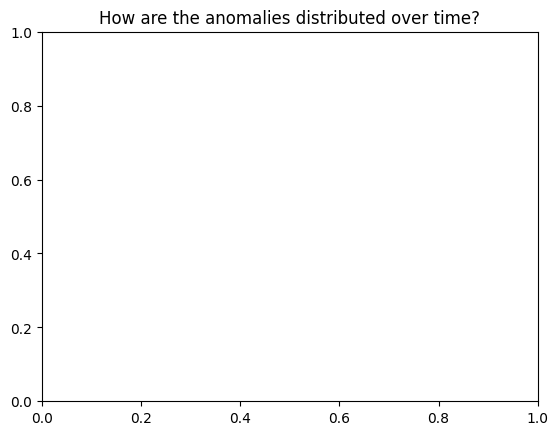

In [29]:

# textgen_config = TextGenerationConfig(n=1, temperature=0.2)
# persona = "I am a security guard at a prison. I want to be able to detect anomalies in the prison environment."
# personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)
# for goal in personal_goals:
#     display(goal)

i = 0
library = "matplotlib"

charts = lida.visualize(summary=summary, goal=goal, textgen_config=textgen_config, library=library)  

for chart in charts:
    try:
        chart.show()
    except Exception as e:
        print(e)

In [50]:
import langchain
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain.prompts import PromptTemplate
from langchain_community.llms.huggingface_hub import HuggingFaceHub
from langchain_community.chat_models import ChatHuggingFace
import os
from dotenv import load_dotenv, get_key

os.environ["HUGGINGFACEHUB_API_TOKEN"] = get_key(key_to_get="HUGGINGFACEHUB_API_KEY",dotenv_path=".env")

llm = HuggingFaceHub(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

def chatwithbot(txt:str):
    prompt = PromptTemplate(template= "You're a helpful database assistant. You've been asked to help Gov. authorities. They want to be able to detect anomalies in the city. They've provided you with a dataset of anomalies in the city which are detected by ML algorithm (YOLO) user doesn't needs to know these techincal terms. Here's the dataset:\n{data}", input_variables=["data"])

    chat_model = ChatHuggingFace(llm=llm)
    # get the data from anomalies.txt
    with open("anomalies.txt", "r") as f:
        data = f.read()
    if len(data) == 0:
        data = "No anomalies detected"

    final_prompt = prompt.format(data=data)
    user_template= PromptTemplate(template="{user_input}", input_variables=["user_input"])

    messages = [
    SystemMessage(content=final_prompt),
    HumanMessage(content=user_template.format(user_input=txt))
    ]
    res = chat_model(messages).content
    res = res[res.find("<|assistant|>")+len("<|assistant|>"):]
    return res


In [51]:

def chat():
    while True:
        txt = input("Enter your message: ")
        if txt == "exit":
            break
        res = chatwithbot(txt)
        print(res)

In [52]:
chat()


Based on the provided dataset, here are some insights:

1. There are multiple instances of both 5 persons and 5 handguns detected in the city. This could indicate a potential increase in criminal activity in the area.

2. The time intervals between the detections are relatively short, suggesting that these incidents may be related and could potentially be part of a larger pattern or event.

3. The presence of steel arms in addition to the handguns could indicate that there may be individuals involved in more serious criminal activities, such as armed robberies or other violent crimes.

4. The fact that the detections are being recorded and stored in a database suggests that there is some sort of surveillance system in place, which could be used to monitor and analyze these incidents in order to identify any trends or patterns that may help to prevent future crimes.

5. The high frequency of detections also raises questions about the effectiveness of current security measures in the ar